In [1]:
import sys
sys.path.append('/Users/rkam/projs/algotrade')
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from src.dbmanager import DBManager
from src.trend_following_rules.sma import SimpleMA
from src.trend_following_rules.lma import LinearMA
from src.trend_following_rules.ema import ExponentialMA

tqdm.pandas()

In [2]:
db = DBManager(path='/Users/rkam/projs/algotrade/data/db/tr.db')

In [3]:
prices = db.read(
    """
    select
        *
    from
        tr
    """
)
prices.columns = ['t', 'd', 'p', 'v']
prices['t'] = pd.to_datetime(prices['t'], format='mixed')
prices['t'] = prices['t'].dt.tz_localize(None)

In [4]:
# filter last day
last_date = prices['t'].dt.date.unique()[-1]
pr = prices[prices['t'].dt.date == last_date]
pr = pr.reset_index(drop=True)

In [5]:
start = datetime(year=2024, month=6, day=11, hour=10)
end = datetime(year=2024, month=6, day=11, hour=18)
pr = pr[(pr['t'] >= start) & (pr['t'] <= end)].reset_index(drop=True)

In [6]:
print(pr.shape)
pr.head()

(31161, 4)


,t,d,p,v
0,2024-06-11 10:00:00.032476,2,317.96,50
1,2024-06-11 10:00:00.033660,1,317.97,18
2,2024-06-11 10:00:00.033660,1,317.97,7
3,2024-06-11 10:00:00.209025,1,317.97,42
4,2024-06-11 10:00:00.209025,1,317.97,58


#### One MA rule

In [93]:
state = 'free' # long, short
price_entry = None

fee = 0.04 / 100

# hyperparams
n = 1000
sl = -0.5
eps = 0.01

ma = ExponentialMA(n)
profits = []

pr['ma'] = None
pr['action'] = None
for i in tqdm(range(0, pr.shape[0]), total=pr.shape[0]):
    p = pr['p'].iloc[i]
    ma_value = ma.get(p)
    if ma_value is None:
        continue
    pr.loc[i, 'ma'] = ma_value
    
    # enter into a deal
    if state == 'free':
        diff = p - ma_value
        if diff > eps:
            state = 'long'
            pr.loc[i, 'action'] = 'open_long'
        elif diff <= -eps:
            state = 'short'
            pr.loc[i, 'action'] = 'open_short'
        else:
            continue
        price_entry = p
        cost = p * fee
    
    # out of the deal
    if state == 'long':
        deviation = p - price_entry
        ma_value = ma.get(p)
        if deviation <= sl or ma_value >= p:
            cost += p * fee
            profits.append(p - price_entry - cost)
            state = 'free'
            pr.loc[i, 'action'] = 'close_long'
    if state == 'short':
        ma_value = ma.get(p)
        deviation = price_entry - p
        if deviation <= sl or ma_value <= p:
            cost += p * fee
            profits.append(price_entry - p - cost)
            state = 'free'
            pr.loc[i, 'action'] = 'close_short'

100%|██████████| 31161/31161 [01:12<00:00, 427.66it/s]


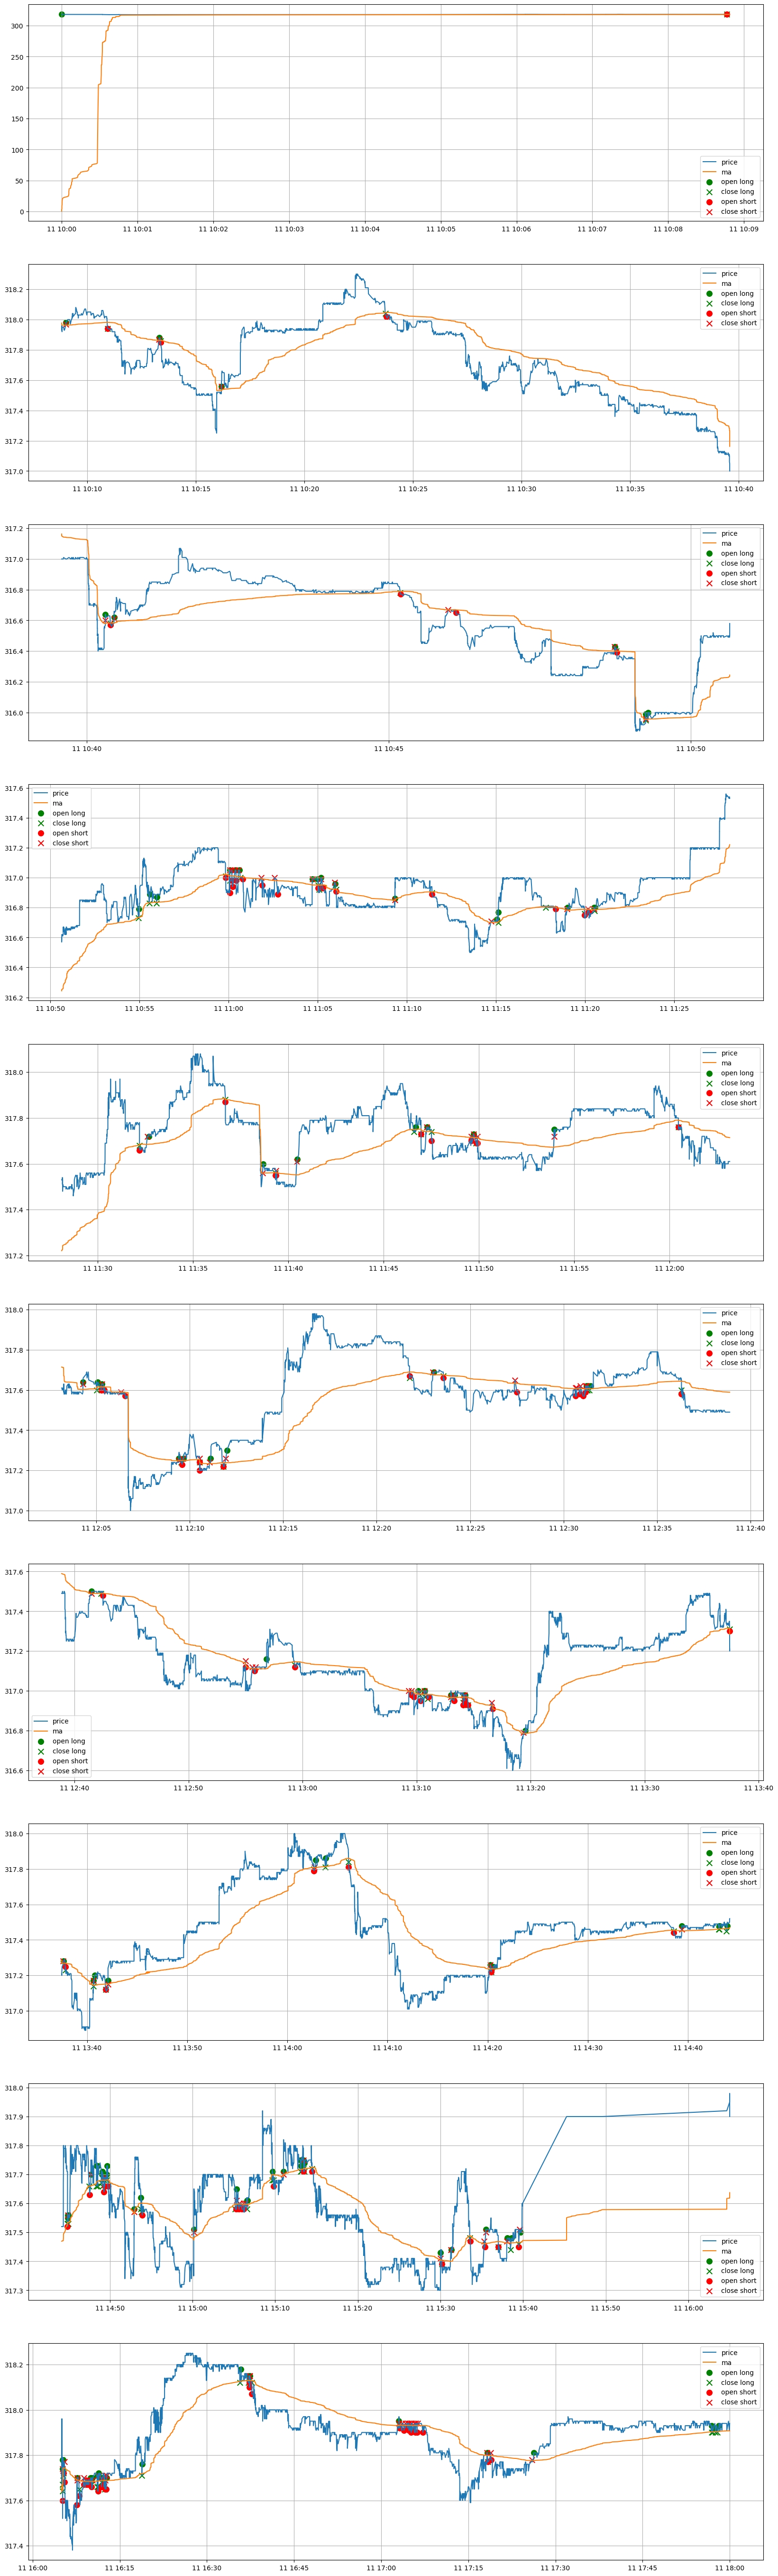

In [95]:
n = 10
fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(20, 7 * n))
indices = list(range(0, pr.shape[0], pr.shape[0] // n))

for i, (left, right) in enumerate(zip(indices[:-1], indices[1:])):
    prf = pr.loc[left:right]
    ax[i].grid(True)
    ax[i].plot(prf.set_index('t')['p'], label='price')
    ax[i].plot(prf.set_index('t')['ma'], label='ma')
    open_long = prf.loc[prf['action'] == 'open_long', ['t', 'p']]
    open_short = prf.loc[prf['action'] == 'open_short', ['t', 'p']]
    close_long = prf.loc[prf['action'] == 'close_long', ['t', 'p']]
    close_short = prf.loc[prf['action'] == 'close_short', ['t', 'p']]
    ax[i].scatter(open_long['t'], open_long['p'], marker='o', color='green', s=70, label='open long')
    ax[i].scatter(close_long['t'], close_long['p'], marker='x', color='green', s=70, label='close long')
    ax[i].scatter(open_short['t'], open_short['p'], marker='o', color='red', s=70, label='open short')
    ax[i].scatter(close_short['t'], close_short['p'], marker='x', color='red', s=70, label='close short')
    ax[i].legend()

#### MA Crossover rule

In [52]:
state = 'free' # long, short
price_entry = None

fee = 0.04 / 100

# hyperparams
n_short = 500
n_long = 2000
sl = -0.5
eps = 0.01

ma_short = ExponentialMA(n_short)
ma_long = ExponentialMA(n_long)
profits = []

pr['ma_short'] = None
pr['ma_longh'] = None
pr['action'] = None
for i in tqdm(range(0, pr.shape[0]), total=pr.shape[0]):
    p = pr['p'].iloc[i]
    ma_value_short = ma_short.get(p)
    ma_value_long = ma_long.get(p)
    if ma_value_long is None:
        continue
    pr.loc[i, 'ma_short'] = ma_value_short
    pr.loc[i, 'ma_long'] = ma_value_long
    
    # enter into a deal
    if state == 'free':
        diff = ma_value_short - ma_value_long
        if diff > eps:
            state = 'long'
            pr.loc[i, 'action'] = 'open_long'
        elif diff <= -eps:
            state = 'short'
            pr.loc[i, 'action'] = 'open_short'
        else:
            continue
        price_entry = p
        cost = p * fee
    
    # out of the deal
    if state == 'long':
        deviation = p - price_entry
        ma_value_short = ma_short.get(p)
        ma_value_long = ma_long.get(p)
        if deviation <= sl or ma_value_long >= ma_value_short:
            cost += p * fee
            profits.append(p - price_entry - cost)
            state = 'free'
            pr.loc[i, 'action'] = 'close_long'
    if state == 'short':
        deviation = price_entry - p
        ma_value_short = ma_short.get(p)
        ma_value_long = ma_long.get(p)
        if deviation <= sl or ma_value_long <= ma_value_short:
            cost += p * fee
            profits.append(price_entry - p - cost)
            state = 'free'
            pr.loc[i, 'action'] = 'close_short'

100%|██████████| 31161/31161 [02:15<00:00, 229.59it/s]


34


<Axes: >

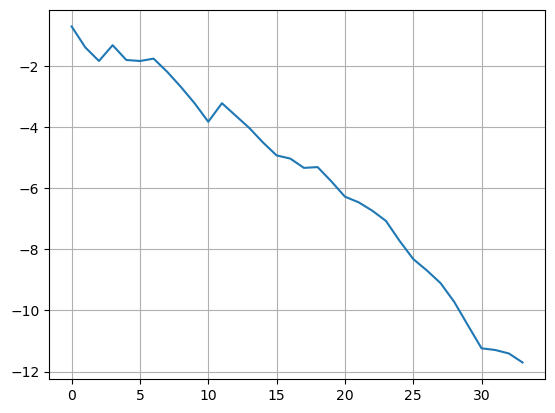

In [53]:
print(len(profits))
pd.Series(profits).cumsum().plot(grid=True)

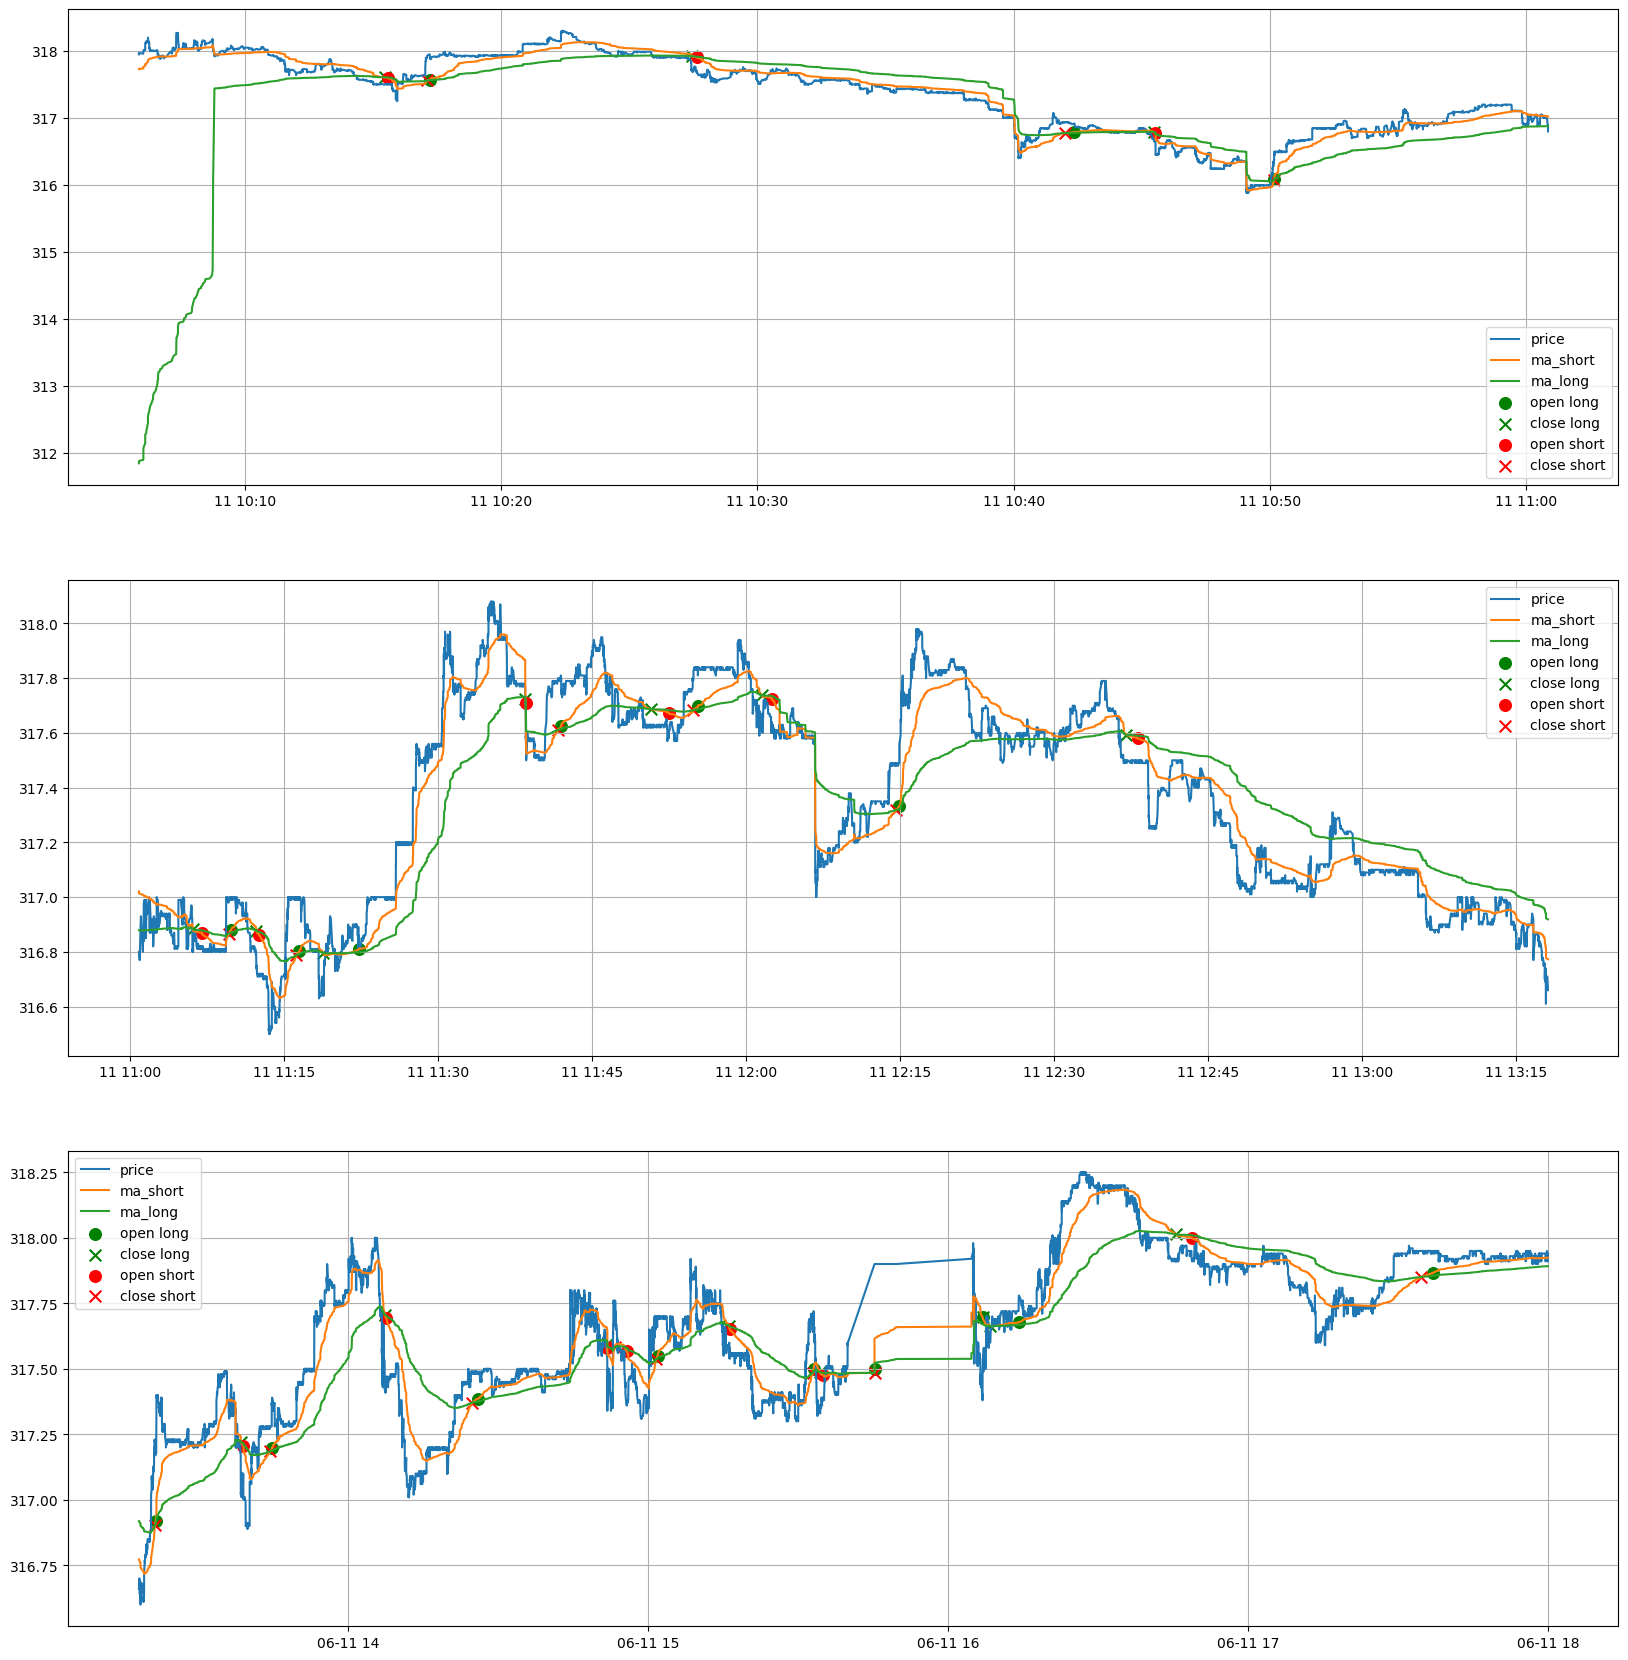

In [56]:
n = 3
fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(20, 7 * n))
indices = list(range(0, pr.shape[0], pr.shape[0] // n))
indices.append(pr.shape[0])


for i, (left, right) in enumerate(zip(indices[:-1], indices[1:])):
    if i == 0:
        prf = pr.loc[left+n_long:right]
    else:
        prf = pr.loc[left:right]
    ax[i].grid(True)
    ax[i].plot(prf.set_index('t')['p'], label='price')
    ax[i].plot(prf.set_index('t')['ma_short'], label='ma_short')
    ax[i].plot(prf.set_index('t')['ma_long'], label='ma_long')
    open_long = prf.loc[prf['action'] == 'open_long', ['t', 'ma_short']]
    open_short = prf.loc[prf['action'] == 'open_short', ['t', 'ma_short']]
    close_long = prf.loc[prf['action'] == 'close_long', ['t', 'ma_short']]
    close_short = prf.loc[prf['action'] == 'close_short', ['t', 'ma_short']]
    ax[i].scatter(open_long['t'], open_long['ma_short'], marker='o', color='green', s=70, label='open long')
    ax[i].scatter(close_long['t'], close_long['ma_short'], marker='x', color='green', s=70, label='close long')
    ax[i].scatter(open_short['t'], open_short['ma_short'], marker='o', color='red', s=70, label='open short')
    ax[i].scatter(close_short['t'], close_short['ma_short'], marker='x', color='red', s=70, label='close short')
    ax[i].legend()

#### MACD rule

In [50]:
state = 'free' # long, short
price_entry = None

fee = 0.04 / 100

# hyperparams
n_short = 500
n_long = 1500
n_target = 1000
sl = -0.5
eps = 0.01

ma_short = ExponentialMA(n_short)
ma_long = ExponentialMA(n_long)
ma_target = ExponentialMA(n_target)
profits = []

pr['ema_short'] = None
pr['ema_long'] = None
pr['mac'] = None
pr['ema_mac'] = None
pr['action'] = None
for i in tqdm(range(0, pr.shape[0]), total=pr.shape[0]):
    p = pr['p'].iloc[i]
    ma_value_short = ma_short.get(p)
    ma_value_long = ma_long.get(p)
    if ma_value_long is None:
        continue
    mac = ma_value_short - ma_value_long
    ema_mac = ma_target.get(mac)
    if ema_mac is None:
        continue
    pr.loc[i, 'ema_short'] = ma_value_short
    pr.loc[i, 'ema_long'] = ma_value_long
    pr.loc[i, 'mac'] = mac
    pr.loc[i, 'ema_mac'] = ema_mac
    
    # enter into a deal
    if state == 'free':
        diff = mac - ema_mac
        if diff > eps:
            state = 'long'
            pr.loc[i, 'action'] = 'open_long'
        elif diff <= -eps:
            state = 'short'
            pr.loc[i, 'action'] = 'open_short'
        else:
            continue
        price_entry = p
        cost = p * fee
    
    # out of the deal
    if state == 'long':
        deviation = p - price_entry
        if deviation <= sl or mac <= ema_mac:
            cost += p * fee
            profits.append(p - price_entry - cost)
            state = 'free'
            pr.loc[i, 'action'] = 'close_long'
    if state == 'short':
        deviation = price_entry - p
        if deviation <= sl or mac >= ema_mac:
            cost += p * fee
            profits.append(price_entry - p - cost)
            state = 'free'
            pr.loc[i, 'action'] = 'close_short'

100%|██████████| 31161/31161 [00:53<00:00, 580.24it/s]


29


<Axes: >

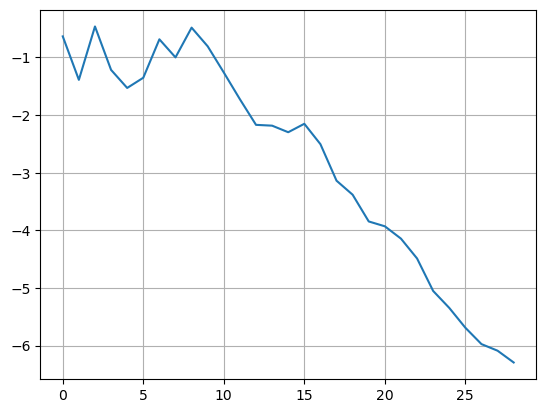

In [51]:
print(len(profits))
pd.Series(profits).cumsum().plot(grid=True)

<Axes: >

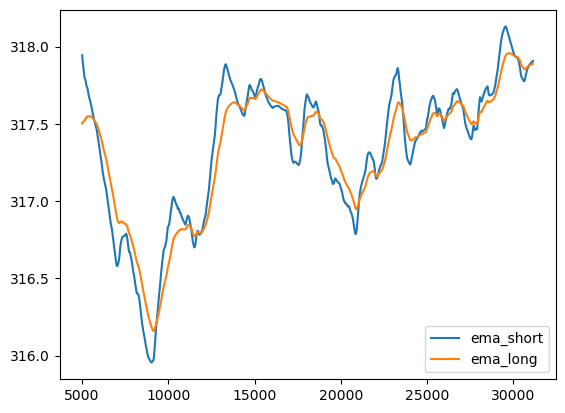

In [52]:
pr[['ema_short', 'ema_long']].iloc[5000:].plot()

<Axes: >

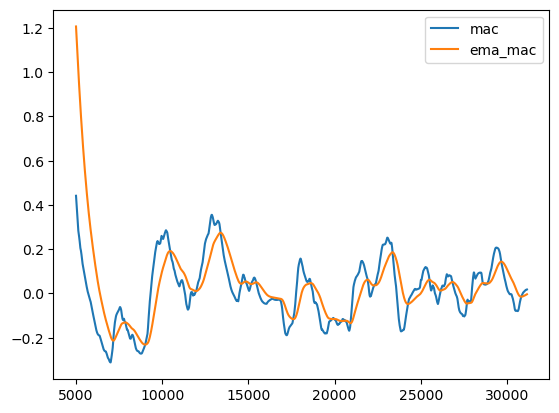

In [47]:
pr[['mac', 'ema_mac']].iloc[5000:].plot()

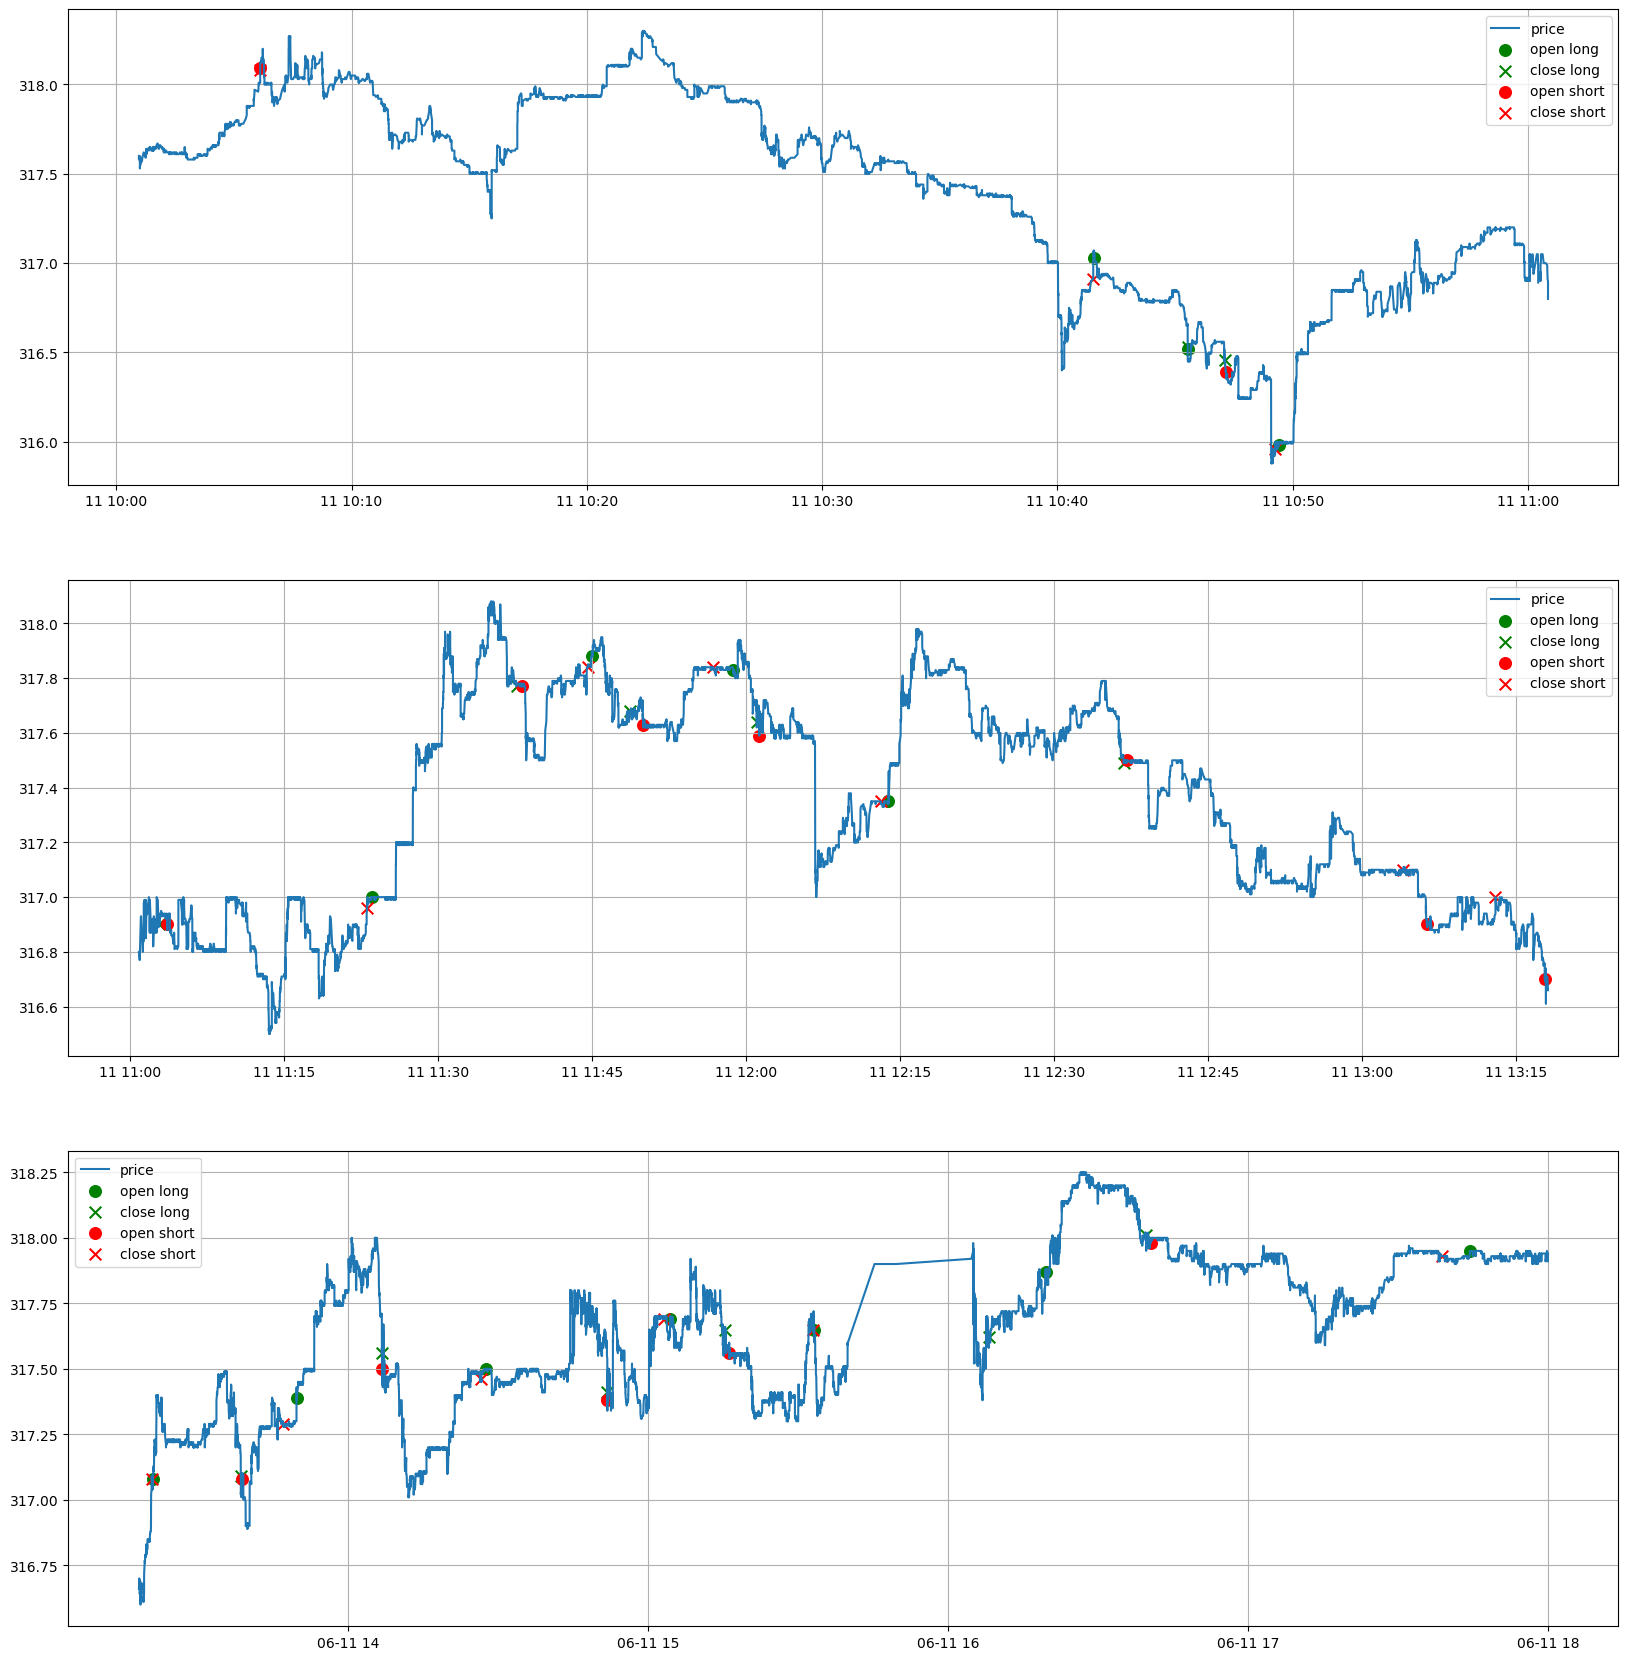

In [53]:
n = 3
fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(20, 7 * n))
indices = list(range(0, pr.shape[0], pr.shape[0] // n))
indices.append(pr.shape[0])


for i, (left, right) in enumerate(zip(indices[:-1], indices[1:])):
    if i == 0:
        prf = pr.loc[left+n_long:right]
    else:
        prf = pr.loc[left:right]
    ax[i].grid(True)
    ax[i].plot(prf.set_index('t')['p'], label='price')
    open_long = prf.loc[prf['action'] == 'open_long', ['t', 'p']]
    open_short = prf.loc[prf['action'] == 'open_short', ['t', 'p']]
    close_long = prf.loc[prf['action'] == 'close_long', ['t', 'p']]
    close_short = prf.loc[prf['action'] == 'close_short', ['t', 'p']]
    ax[i].scatter(open_long['t'], open_long['p'], marker='o', color='green', s=70, label='open long')
    ax[i].scatter(close_long['t'], close_long['p'], marker='x', color='green', s=70, label='close long')
    ax[i].scatter(open_short['t'], open_short['p'], marker='o', color='red', s=70, label='open short')
    ax[i].scatter(close_short['t'], close_short['p'], marker='x', color='red', s=70, label='close short')
    ax[i].legend()